In [22]:
import os
import cv2
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from glob import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
from pathlib import Path
import random

In [23]:
# Load sample image + xml
image_path = "../data/images/train/BikesHelmets1.png"
xml_path = "../data/annotations/BikesHelmets1.xml"

In [24]:
# Parse XML (Pascal VOC format)
tree = ET.parse(xml_path)
root = tree.getroot()


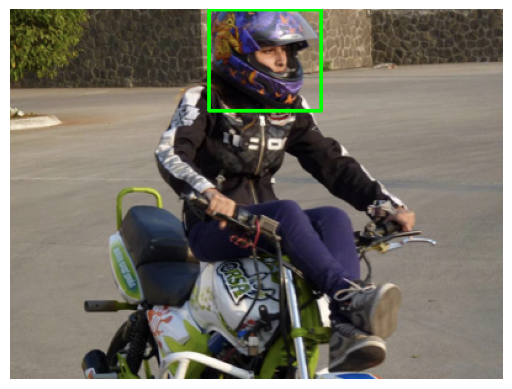

In [25]:
# Draw bounding boxes
img = cv2.imread(image_path)
for obj in root.findall("object"):
    label = obj.find("name").text # type: ignore
    bbox = obj.find("bndbox")
    xmin, ymin, xmax, ymax = [int(bbox.find(t).text) for t in ["xmin", "ymin", "xmax", "ymax"]] # type: ignore
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 2) #type: ignore
    cv2.putText(img, label, (xmin, ymin - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2) #type: ignore

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)) # type: ignore
plt.axis("off")
plt.show()

In [26]:
# Define augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.MotionBlur(p=0.2),
], bbox_params=A.BboxParams(format="pascal_voc", label_fields=["labels"]))

In [27]:
# Example augmentation
bboxes = [[xmin, ymin, xmax, ymax]]   # from XML
labels = [label]

augmented = transform(image=img, bboxes=bboxes, labels=labels)

aug_img = augmented["image"]
aug_bboxes = augmented["bboxes"]


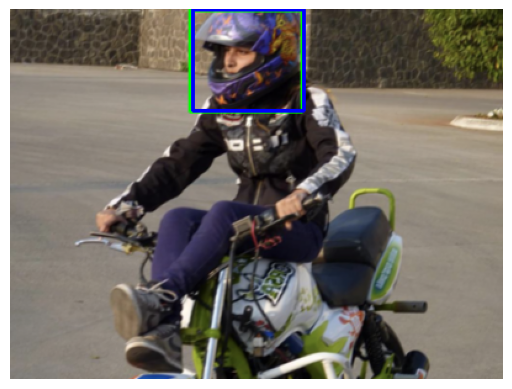

In [28]:
# Draw augmented result
for (xmin, ymin, xmax, ymax), lbl in zip(aug_bboxes, labels):
    cv2.rectangle(aug_img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255,0,0), 2)
    cv2.putText(aug_img, lbl, (int(xmin), int(ymin)-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,0,0), 2) # type: ignore

plt.imshow(cv2.cvtColor(aug_img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [29]:
# Save augmented image
os.makedirs("data/augmented", exist_ok=True)
cv2.imwrite("data/augmented/example1_aug.jpg", aug_img)


True

In [41]:
from pathlib import Path
IMAGE_DIR = "../data/images/train"
LABEL_DIR = "../data/labels/train"
CLASS_NAMES = ['helmet', 'no_helmet']
IMAGE_DIR = Path(IMAGE_DIR)       # convert to Path object
LABEL_DIR = Path(LABEL_DIR)       # convert to Path object

In [33]:
# Augmentation pipeline
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3),
    A.GaussianBlur(p=0.2)
], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))


In [ ]:
# Load YOLO labels
# -------------------------
def load_yolo_labels(label_path):
    """Load YOLO format bounding boxes from txt file"""
    boxes, labels = [], []
    if not os.path.exists(label_path):
        return boxes, labels
    with open(label_path, "r") as f:
        for line in f.readlines():
            cls, x, y, w, h = map(float, line.strip().split())
            boxes.append([x, y, w, h])
            labels.append(int(cls))  # ensure int here
    return boxes, labels

In [ ]:
def draw_boxes(img, boxes, labels, color=(0,255,0)):
    """Draw YOLO-format boxes on an image"""
    h, w = img.shape[:2]
    for box, label in zip(boxes, labels):
        # Make sure label is integer index
        label = int(round(float(label)))

        # YOLO format: [x_center, y_center, width, height] (normalized)
        x, y, bw, bh = box
        x1 = int((x - bw/2) * w)
        y1 = int((y - bh/2) * h)
        x2 = int((x + bw/2) * w)
        y2 = int((y + bh/2) * h)

        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, CLASS_NAMES[label], (x1, y1-5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
    return img

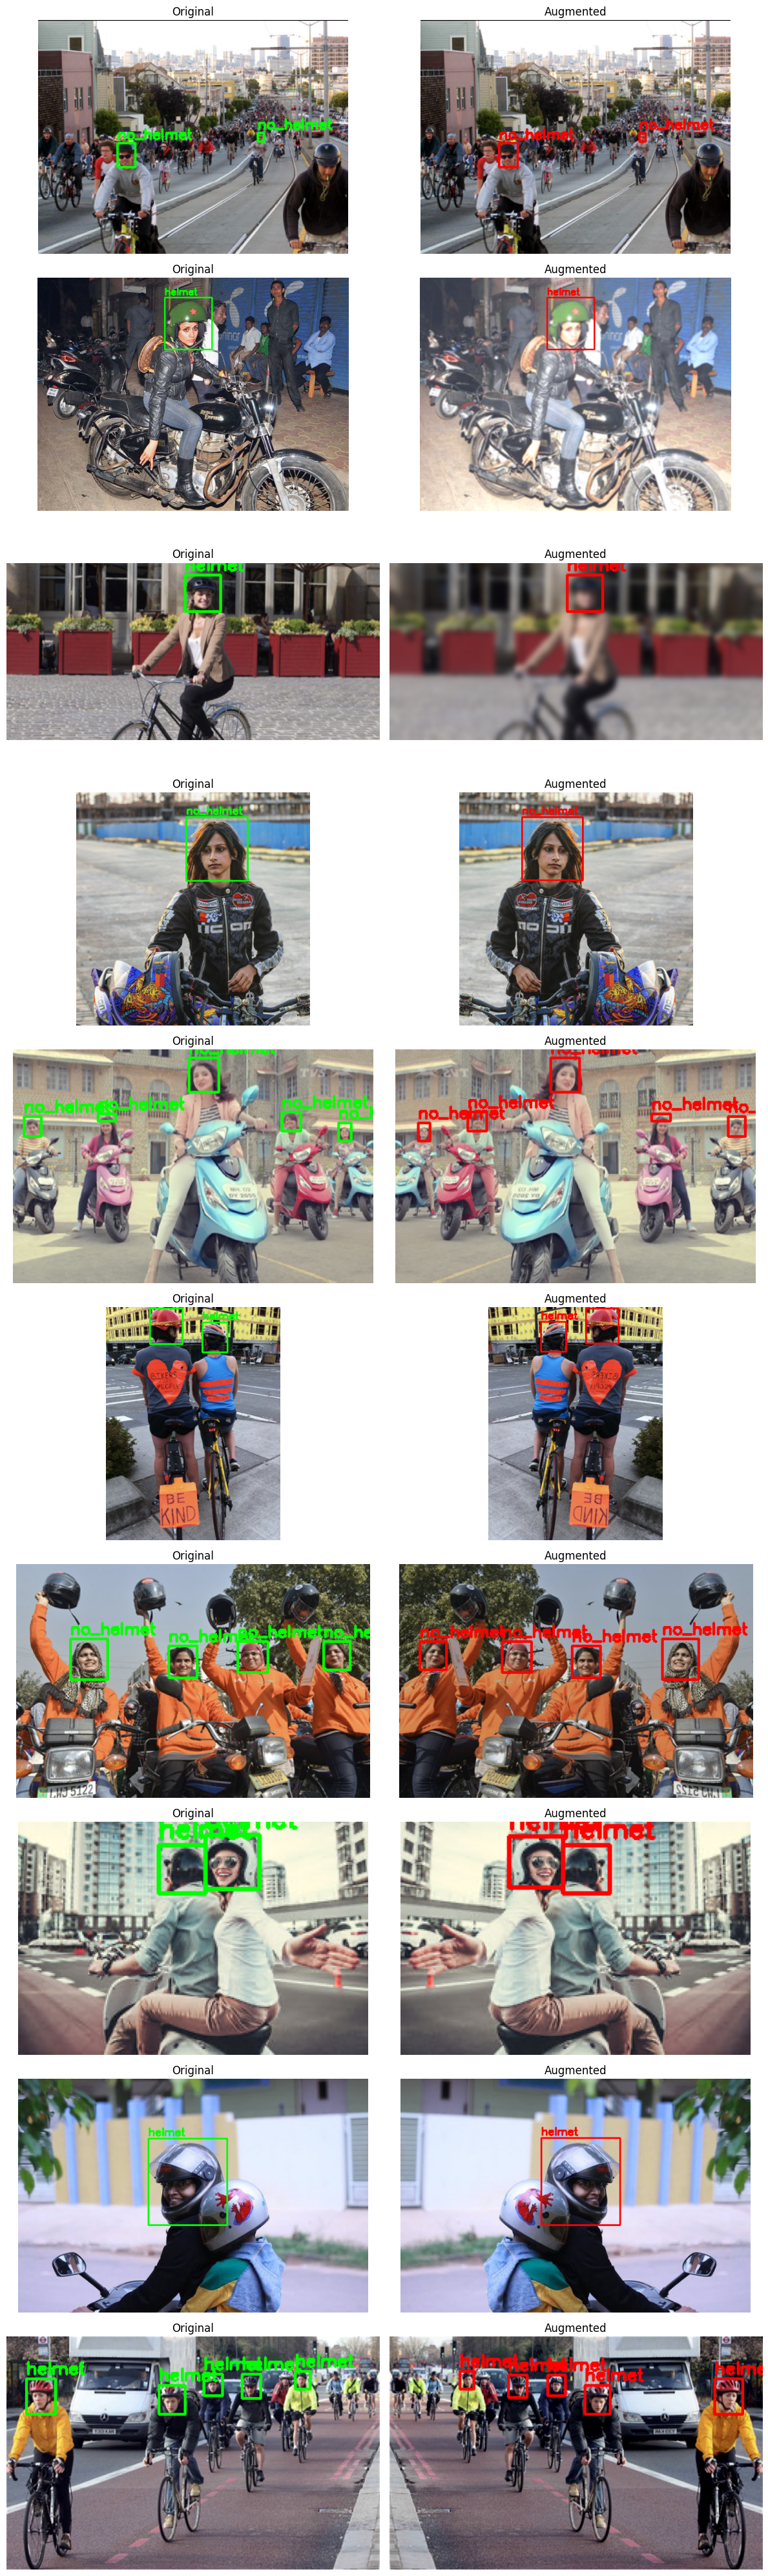

In [ ]:
def visualize_samples(n=3):
    """Show original vs augmented images with YOLO boxes"""
    # Support both PNG and JPG
    all_images = list(IMAGE_DIR.glob("*.png")) + list(IMAGE_DIR.glob("*.jpg")) # type: ignore

    if not all_images:
        print(f"⚠️ No images found in {IMAGE_DIR}")
        return

    # Prevent sampling errors
    n_samples = min(n, len(all_images))
    sample_imgs = random.sample(all_images, n_samples)

    plt.figure(figsize=(12, n_samples*4))

    idx = 0
    for img_path in sample_imgs:
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"⚠️ Could not read {img_path}")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Corresponding label file
        label_path = LABEL_DIR / (img_path.stem + ".txt") # type: ignore
        if not label_path.exists():
            print(f"⚠️ Skipping {img_path.name} (no label file)")
            continue

        boxes, labels = load_yolo_labels(label_path)

        # Draw original
        img_orig = draw_boxes(img.copy(), boxes, labels, (0,255,0))

        # Apply augmentation
        transformed = transform(image=img, bboxes=boxes, class_labels=labels)

        # Ensure augmented labels are ints
        transformed['class_labels'] = [int(round(float(l))) for l in transformed['class_labels']]

        img_aug = draw_boxes(
            transformed['image'].copy(),
            transformed['bboxes'],
            transformed['class_labels'],
            (255,0,0)
        )

        # Show side by side
        plt.subplot(n_samples, 2, 2*idx+1)
        plt.imshow(img_orig)
        plt.title("Original")
        plt.axis("off")

        plt.subplot(n_samples, 2, 2*idx+2)
        plt.imshow(img_aug)
        plt.title("Augmented")
        plt.axis("off")

        idx += 1

    plt.tight_layout()
    plt.show()
visualize_samples(n=10)

ValueError: Sample larger than population or is negative